# Learn with Linear Model

Use a linear model to learn weights for draco. 

In [1]:
from draco.learn import linear

%config InlineBackend.figure_format = 'retina'

Train score:  1.0
Dev score:  1.0


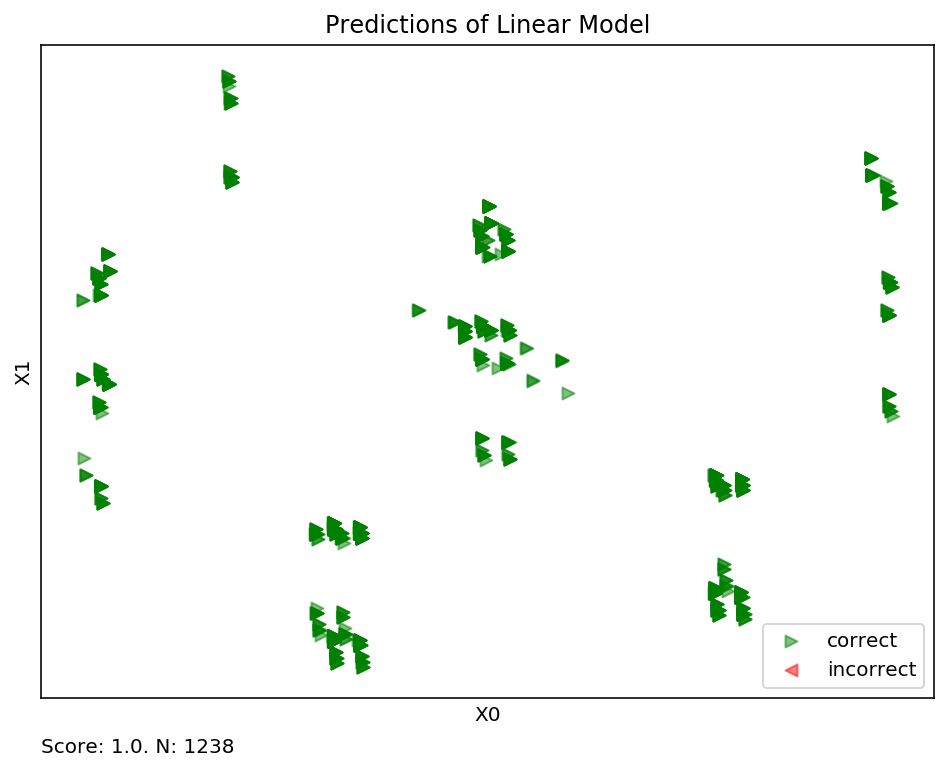

CPU times: user 945 ms, sys: 129 ms, total: 1.07 s
Wall time: 809 ms


LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=False,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [2]:
%time linear.main()